<a href="https://colab.research.google.com/github/solobala/RMSL_9/blob/main/NLP8_DZ1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация по тональности
В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.



## Импорт библиотек и пользовательские функции

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation

In [2]:
import json
import bz2
import re
import regex
from tqdm import tqdm
from scipy import sparse
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel, delayed
%matplotlib inline
%pylab inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.style.use('ggplot')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk import FreqDist

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Populating the interactive namespace from numpy and matplotlib


In [3]:
!pip install pymorphy2
!pip install pymorphy2-dicts-ru

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 18.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=b95284a73d66597877a5cbcd9979aff8809d1d12efdb45f3c072ef67f212cd82
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
from nltk.corpus import stopwords

In [6]:
from string import punctuation

## Загрузка и предобработка датасета

In [7]:
# Формируем список отзывов
responses = []
with bz2.BZ2File('/content/drive/MyDrive/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [03:14, 1033.71it/s]


In [8]:
# Посмотрим на пример отзыва:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [9]:
# Преобразуем список в датасрейм
df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [11]:
df['text'] = df['text'].astype(str).apply(lambda x: x.lower()) # преобразуем  внижний регистр

## Часть 1. Анализ текстов

### Посчитайте количество отзывов в разных городах

In [11]:
df1 = df.copy()

In [12]:
df1.dropna(subset=['city'], inplace=True, axis=0) # Уберем запуски с пропущенными значениямив City

In [13]:
df1['city'] = df1['city'].astype(str).apply(lambda x: x.lower().replace('г. ', '').replace('г.', "").replace('г ', "").replace('город ', "").replace('п.', "").replace('пгт.', "").replace('пгт', "").replace('(', "").replace(')',""))

In [14]:
# Получим кол-во записей по топ 100 городов с наибольшим количеством отзывов.
df1['city'].value_counts()[:100].sum()

120756

In [15]:
# более 87% всех отзывов - по топ100 городам. Остальное - это опечатки,  города с небольшим количеством отзывов и пр. - можно не рассматривать
print(f'{round(df1["city"].value_counts()[:100].sum()/df1.shape[0]*100,2)}%')

87.3%


In [16]:
# Выведем список таких городов  в порядке убывания
df1['city'].value_counts()[:100]

москва             56787
санкт-петербург    14664
новосибирск         2383
екатеринбург        2378
нижний новгород     2038
                   ...  
электросталь         130
стерлитамак          118
благовещенск         117
якутск               117
серпухов             113
Name: city, Length: 100, dtype: int64

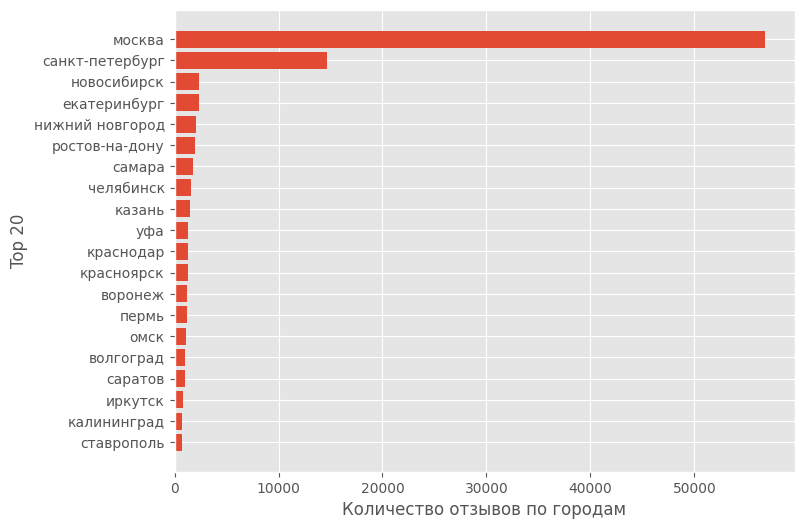

In [17]:
cities = df1.groupby(['city']).count()['text'].sort_values(ascending=False).head(20)
rcParams['figure.figsize'] = 8, 6
plt.barh(cities.index[::-1],cities.values[::-1])
plt.xlabel('Количество отзывов по городам')
plt.ylabel('Top 20')
plt.show()

### Посчитайте количество отзывов на разные банки

In [18]:
df['bank_name'].value_counts()

Сбербанк России     26327
Альфа-Банк          10224
ВТБ 24               8185
Русский Стандарт     7943
Хоум Кредит Банк     7549
                    ...  
Сиббизнесбанк           1
Донбанк                 1
Потенциал               1
Ури Банк                1
БайкалИнвестБанк        1
Name: bank_name, Length: 670, dtype: int64

In [19]:
df['bank_name'] = df['bank_name'].astype(str).apply(lambda x: x.lower())

In [20]:
df['bank_name'].value_counts()[:50].sum()

133324

In [22]:
# Почти 87% приходится на топ50 банков. Остальные = опечатки и банки с небольшим количеством отзывов = можно не принимать во внимамние
print(f'{round(df["bank_name"].value_counts()[:50].sum()/df.shape[0]*100,2)}%')

86.86%


In [23]:
df['bank_name'].value_counts()[:50] # На рисунке - только 20 банков, иначе плохо видно

сбербанк россии                                         26327
альфа-банк                                              10224
втб 24                                                   8185
русский стандарт                                         7943
хоум кредит банк                                         7549
тинькофф банк                                            5387
национальный банк «траст»                                4607
ренессанс кредит                                         3849
связной банк                                             3775
отп банк                                                 3237
восточный экспресс банк                                  3138
райффайзенбанк                                           3057
московский кредитный банк                                2944
ситибанк                                                 2848
авангард                                                 2733
промсвязьбанк                                            2586
юникреди

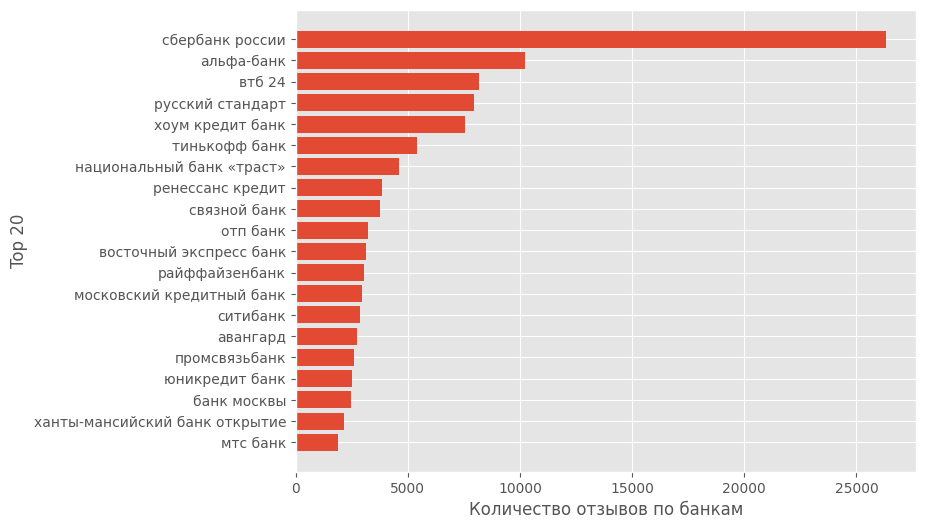

In [24]:
banks = df.groupby(['bank_name']).count()['text'].sort_values(ascending=False).head(20)
rcParams['figure.figsize'] = 8, 6
plt.barh(banks.index[::-1],banks.values[::-1])
plt.xlabel('Количество отзывов по банкам')
plt.ylabel('Top 20')
plt.show()

### Постройте гистограмы длин слов в символах и в словах

In [33]:
texts = df['text'].to_list()
lengths = list(map(len, texts))
word_counts = list(map(lambda text: len(text.split()), texts))

In [39]:
lengths = [x for x in lengths if x<10000]

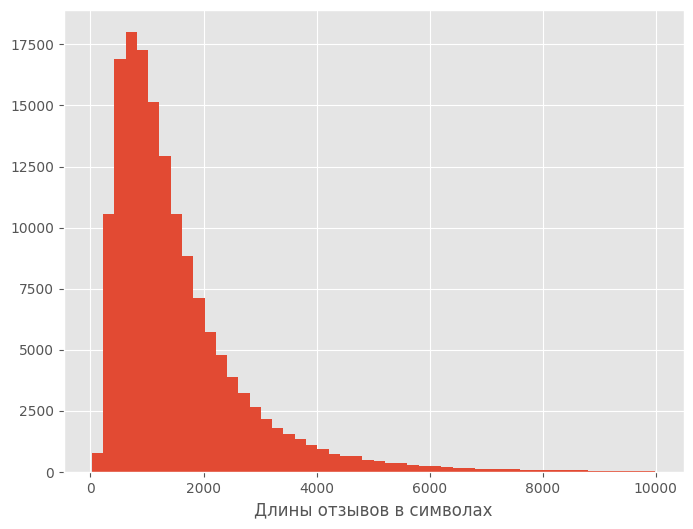

In [40]:
rcParams['figure.figsize'] = 8, 6
plt.hist(x=lengths, bins=50)
plt.xlabel('Длины отзывов в символах')
plt.ylabel('')
plt.show()

In [41]:
word_counts = [x for x in word_counts if x<2000]

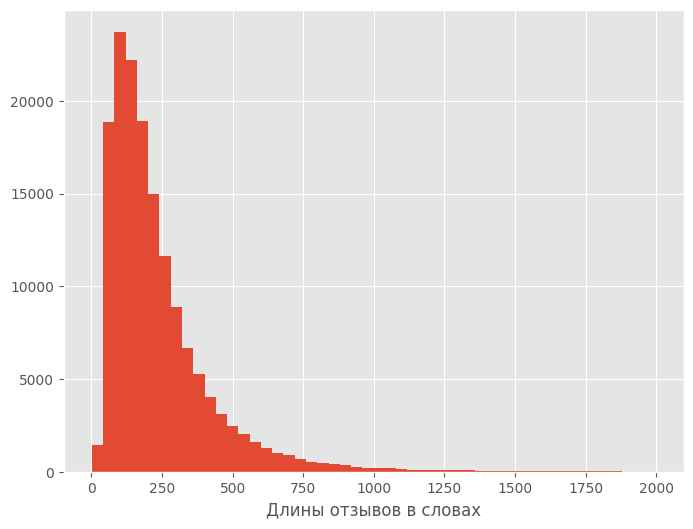

In [42]:
rcParams['figure.figsize'] = 8, 6
plt.hist(x=word_counts, bins=50)
plt.xlabel('Длины отзывов в словах')
plt.ylabel('')
plt.show()

## Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм
    * существительных

In [44]:
noise = stopwords.words('russian') + list(punctuation) + ['``', "''", '...', 'это', ' ', ', ', '  ', ' - ', ' "', ' )',' (', 'т', 'сч', 'е', 'сих', 'мой']

In [26]:
def remove_stopwords(text, mystopwords=noise):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [27]:
df['text_tokenized'] =  df.text.str.lower().apply(words_only)
df['text_tokenized_stop_worlds'] = df.text_tokenized.str.lower().apply(remove_stopwords)

In [28]:
import multiprocessing as mp
import pymorphy2

# создание объекта лемматизатора
morph = pymorphy2.MorphAnalyzer()
# функция для лемматизации одного слова
def lemmatize_word(word):
    return morph.parse(word)[0].normal_form

# функция для лемматизации текста в отдельном потоке
def process_text(text):
    words = text.split()
    with mp.Pool() as pool:
        lemmas = pool.map(lemmatize_word, words)
    return ' '.join(lemmas)

def lemmatize(text):
    from pymystem3 import Mystem
    m = Mystem()
    merged_text = "|".join(text)

    doc = []
    res = []

    for t in m.lemmatize(merged_text):
        if t != '|':
            doc.append(t)
        else:
            res.append(doc)
            doc = []

    return res

In [45]:
# Самые частотные слова
corpus = [token for response in df.text_tokenized for token in word_tokenize(response)]
freq_dict = Counter(corpus)
print('10 самых частых слов  в отзывах')
freq_dict.most_common(10)

10 самых частых слов  в отзывах


[('в', 1330550),
 ('и', 1058997),
 ('не', 855335),
 ('на', 707935),
 ('что', 640057),
 ('я', 577500),
 ('с', 464037),
 ('по', 372769),
 ('мне', 320958),
 ('банка', 275906)]

In [46]:
# самые частотные слова без учета стоп-слов
corpus = [token for response in df.text_tokenized_stop_worlds for token in word_tokenize(response)]
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('банка', 275906),
 ('банк', 215426),
 ('деньги', 131201),
 ('карту', 105829),
 ('карты', 101821),
 ('кредит', 81136),
 ('день', 76552),
 ('банке', 72169),
 ('заявление', 70423),
 ('очень', 66824)]

In [72]:
%pip install pymystem3

In [73]:
from pymystem3 import Mystem
m = Mystem()

In [75]:
def to_lemmas(text, mystem=m):
    tokens = text.split()
    lemmas = [m.lemmatize(token)[0] for token in tokens]
    return ' '.join(lemmas)


In [76]:
mylist = df['text_tokenized_stop_worlds'].to_list()
lemmatized_texts =[]
for item in tqdm(mylist):
  lemmatized_texts.append(to_lemmas(item, mystem=m))

100%|██████████| 153499/153499 [40:23<00:00, 63.34it/s] 


In [77]:
lemmatized_texts[2]

'здравствовать дублировать свое заявление можайский я мой дебетовый карта совершать покупка интернет магазин сумма руб карта происходить двойной списание раз руб руб иметься смс сообщение банка интернет магазин подтверждать платеж руб товар получать просить разбираться ситуация вернуть счет ошибочный списывать сумма размер руб уважение давний клиент ваш банка владимир номер карта указывать мой заявление можайский'

In [79]:
# каждая строка состоит из лемм.
lemmas=[]
for row in tqdm(lemmatized_texts):
  words = row.split()
  for word in words:
    lemmas.append(word)

100%|██████████| 153499/153499 [00:11<00:00, 13016.85it/s]


In [80]:
# Самые частые леммы
freq_dict_lem = Counter(lemmas)
print('10 самых частых лемм в отзывах')
freq_dict_lem.most_common(10)


[('банк', 364704),
 ('карта', 334999),
 ('банка', 303889),
 ('деньги', 179734),
 ('день', 172952),
 ('мой', 163042),
 ('кредит', 156177),
 ('который', 149037),
 ('отделение', 144050),
 ('клиент', 136892)]

In [91]:
# Существительные
nouns = []
for key, value in tqdm(freq_dict_lem.items()):
  if 'NOUN' in morph.parse(key)[0].tag:
    i=0
    while i < value:
      nouns.append(key)
      i+=1

100%|██████████| 91290/91290 [00:31<00:00, 2887.23it/s]


In [92]:
freq_dict = Counter(nouns)
print('10 самых частых существительных в отзывах')
freq_dict.most_common(10)

10 самых частых существительных в отзывах


[('банк', 364704),
 ('карта', 334999),
 ('банка', 303889),
 ('деньги', 179734),
 ('день', 172952),
 ('кредит', 156177),
 ('отделение', 144050),
 ('клиент', 136892),
 ('сотрудник', 134168),
 ('счет', 126894)]


### Постройте кривые Ципфа и Хипса

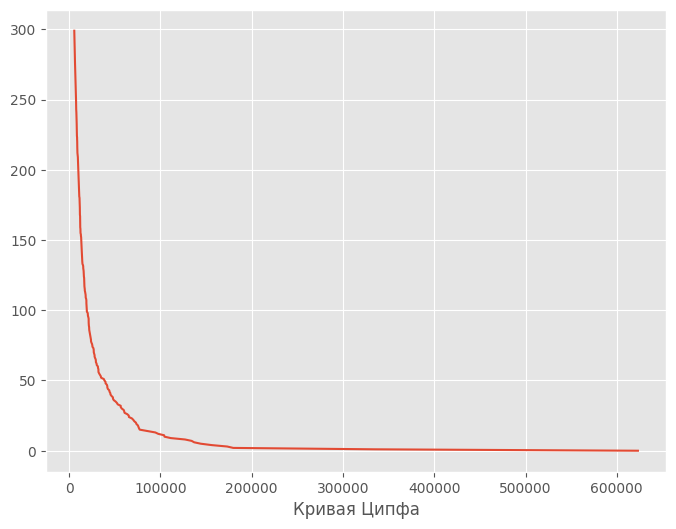

In [68]:
# кривая Ципфа (для существительных)
freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)
fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.xlabel('Кривая Ципфа')
plt.ylabel('')
plt.show()

In [42]:
# кривая Хипса
cnt = Counter()
n_words = []
n_tokens = []
tokens = []

for index, row in tqdm(df.iterrows(), total=len(df)):
    tokens = word_tokenize(row['text_tokenized_stop_worlds'])
    cnt.update([token for token in tokens])
    n_words.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))

100%|██████████| 153499/153499 [54:37<00:00, 46.83it/s]


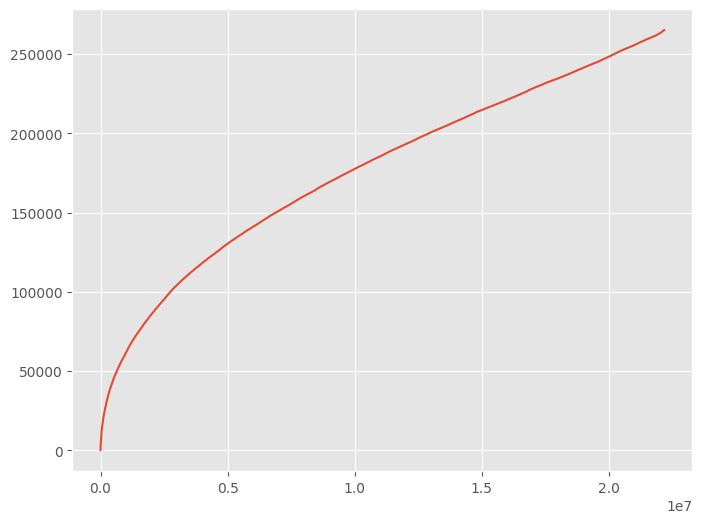

In [43]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.show()

### Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?

In [93]:
freq_dict = Counter(nouns)

In [94]:
# какое слово встречается чаще, "сотрудник" или "клиент"?

print('Слово "сотрудник" встречается -"',freq_dict['сотрудник'],'раз')
print('Слово "клиент" встречается -"',freq_dict['клиент'],'раз')

Слово "сотрудник" встречается -" 134168 раз
Слово "клиент" встречается -" 136892 раз


Вывод: слово "клиент" встречается чаще

In [95]:
# Сколько раз встречаются слова  "мошенничество" и "доверие"
print('Слово "мошенничество" встречается -"', freq_dict['мошенничество'],'раз')
print('Слово "доверие" встречается -"',freq_dict['доверие'],'раз')

Слово "мошенничество" встречается -" 3244 раз
Слово "доверие" встречается -" 2108 раз


### В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [96]:
df['lemmas'] = lemmatized_texts

In [104]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,text_tokenized,text_tokenized_stop_worlds,lemmas
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,добрый день я не являюсь клиентом банка и пору...,добрый день являюсь клиентом банка поручителем...,добрый день являться клиент банка поручитель к...
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,сбербанк россии,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,доброго дня являюсь держателем зарплатной карт...,доброго дня являюсь держателем зарплатной карт...,добрый день являться держатель зарплатной карт...
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,здравствуйте дублирую свое заявление от в до м...,здравствуйте дублирую свое заявление можайский...,здравствовать дублировать свое заявление можай...
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,сбербанк россии,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,добрый день я открыл расчетный счет в сбербанк...,добрый день открыл расчетный счет сбербанке юр...,добрый день открывать расчетный счет сбербанк ...
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,отп банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,г взяла кредит в вашем банке заявленная мною с...,г взяла кредит вашем банке заявленная мною сум...,г взять кредит ваш банк заявлять я сумма рубль...


In [97]:
positives = df[df['rating_grade']==5]['lemmas'].to_list() # Это все положительные отзывы
negatives = df[df['rating_grade']==1]['lemmas'].to_list() # Это все отрицательные отзывы
batch_size = 1000
text_batch_pos = [positives[i: i + batch_size] for i in range(0, len(positives), batch_size)] # Это батчи по 1000 позитивных отзывов
text_batch_neg = [negatives[i: i + batch_size] for i in range(0, len(negatives), batch_size)] # это батчи по 1000 отрицательных отзывов

In [98]:
len(positives)

14713

In [99]:
len(negatives)

47387

In [100]:
def find_ngram(text, n):
    """ находит n-граммы
    на входе - список из слов
    на выходе - список n-Грамм
    """
    return list(ngrams(text.split(), n))

добрый день являться клиент банка поручитель

In [107]:
def find_key_ngrams(processed_texts, n, m):
    """ возвращает n наиболее часто встречающихся m-грамм в корпусе
    На входе - список -батч отзывов размером batch_size
    """
    result = []
    # Берем по одному лемматизированному отзыву из батча
    for item in processed_texts:
        # и находим  в нем m-Граммы
        result += find_ngram(item, m)
    return result

In [108]:
from nltk import ngrams
print('Ключевые слова в положительных отзывах')
result = []
for batch in tqdm(text_batch_pos):
  result += find_key_ngrams(batch, 10, 1)
freq_dict = Counter(result)
freq_dict.most_common(10)

Ключевые слова в положительных отзывах


100%|██████████| 15/15 [00:00<00:00, 24.72it/s]


[(('банк',), 39012),
 (('банка',), 26332),
 (('карта',), 25129),
 (('очень',), 15695),
 (('кредит',), 13613),
 (('день',), 13604),
 (('клиент',), 13319),
 (('отделение',), 13020),
 (('который',), 12061),
 (('сотрудник',), 11788)]

In [109]:
print('Биграммы в положительных отзывах')
result = []
for batch in tqdm(text_batch_pos):
  result += find_key_ngrams(batch, 10, 2)
freq_dict = Counter(result)
freq_dict.most_common(10)

Биграммы в положительных отзывах


100%|██████████| 15/15 [00:00<00:00, 20.01it/s]


[(('кредитный', 'карта'), 2782),
 (('интернет', 'банк'), 2597),
 (('сотрудник', 'банка'), 2533),
 (('другой', 'банк'), 2309),
 (('клиент', 'банка'), 1801),
 (('следующий', 'день'), 1525),
 (('открывать', 'вклад'), 1523),
 (('являться', 'клиент'), 1438),
 (('отделение', 'банка'), 1415),
 (('дебетовый', 'карта'), 1150)]

In [110]:
print('Ключевые слова в отрицательных отзывах')
result = []
for batch in tqdm(text_batch_neg):
  result += find_key_ngrams(batch, 10, 1)
freq_dict = Counter(result)
freq_dict.most_common(10)

Ключевые слова в отрицательных отзывах


100%|██████████| 48/48 [00:04<00:00, 10.28it/s]


[(('банк',), 121657),
 (('карта',), 116026),
 (('банка',), 106545),
 (('деньги',), 69589),
 (('день',), 65827),
 (('мой',), 60584),
 (('отделение',), 59572),
 (('который',), 55155),
 (('кредит',), 53387),
 (('сотрудник',), 52989)]

In [111]:
print('Биграммы в отрицательных отзывах')
result = []
for batch in tqdm(text_batch_neg):
  result += find_key_ngrams(batch, 10, 2)
freq_dict = Counter(result)
freq_dict.most_common(10)

Биграммы в отрицательных отзывах


100%|██████████| 48/48 [00:03<00:00, 15.85it/s]


[(('сотрудник', 'банка'), 14292),
 (('кредитный', 'карта'), 9946),
 (('отделение', 'банка'), 9762),
 (('денежный', 'средство'), 9389),
 (('написать', 'заявление'), 9230),
 (('горячий', 'линия'), 7403),
 (('рабочий', 'день'), 5894),
 (('колл', 'центр'), 5813),
 (('следующий', 'день'), 5154),
 (('служба', 'поддержка'), 4871)]

## Часть 2. Тематическое моделирование

### 2.1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

In [112]:
import gensim.corpora as corpora
from gensim.models import ldamodel

In [113]:
texts = [df['lemmas'].iloc[i].split() for i in range(len(df))]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [114]:
lda = ldamodel.LdaModel(corpus=corpus,
                        id2word=dictionary,
                        num_topics=20,
                        alpha='auto',
                        eta='auto',
                        iterations = 20,
                        passes = 5,
                        random_state=42)

In [117]:
# 20 тем, рандомная выборка 5
lda.show_topics(5)

[(18,
  '0.047*"доллар" + 0.046*"курс" + 0.036*"покупка" + 0.036*"евро" + 0.033*"рубль" + 0.032*"валюта" + 0.031*"магазин" + 0.018*"связной" + 0.016*"акция" + 0.015*"валютный"'),
 (9,
  '0.046*"кредит" + 0.035*"договор" + 0.031*"документ" + 0.017*"квартира" + 0.017*"сделка" + 0.015*"страховка" + 0.012*"менеджер" + 0.012*"оформлять" + 0.012*"подписывать" + 0.012*"банка"'),
 (12,
  '0.037*"очень" + 0.022*"банка" + 0.021*"банк" + 0.020*"обслуживание" + 0.015*"сотрудник" + 0.014*"быстро" + 0.013*"вопрос" + 0.013*"работа" + 0.012*"спасибо" + 0.011*"офис"'),
 (3,
  '0.025*"день" + 0.024*"сказать" + 0.016*"позвонить" + 0.013*"звонить" + 0.013*"говорить" + 0.013*"девушка" + 0.011*"вопрос" + 0.010*"приходить" + 0.010*"отвечать" + 0.010*"ответ"'),
 (17,
  '0.034*"банк" + 0.016*"клиент" + 0.015*"банка" + 0.012*"который" + 0.011*"свой" + 0.010*"такой" + 0.008*"просто" + 0.007*"проблема" + 0.007*"один" + 0.007*"другой"')]

Темы:
* Покупка и продажа валюты
* Кредиты
* Хорошее обслуживание клиентов в банке
* Общение по телефону с сотрудниками банка

In [115]:
del df1

In [116]:
df.drop(columns=['datetime', 'text', 'text_tokenized', 'text_tokenized_stop_worlds', 'city', 'rating_not_checked', 'num_comments', 'author', 'bank_license'], inplace=True)

In [118]:
del lda

In [119]:
lda15 = ldamodel.LdaModel(corpus=corpus,
                          id2word=dictionary,
                          num_topics=15,
                          alpha='auto',
                          eta='auto',
                          iterations = 20,
                          passes = 5)

In [120]:
# 15 тем, рандомная выборка 5
lda15.show_topics(5)

[(8,
  '0.034*"договор" + 0.027*"банк" + 0.020*"рф" + 0.013*"закон" + 0.012*"лицо" + 0.012*"право" + 0.010*"требование" + 0.009*"суд" + 0.009*"банковский" + 0.008*"п"'),
 (13,
  '0.118*"вклад" + 0.045*"открывать" + 0.028*"процент" + 0.027*"депозит" + 0.025*"договор" + 0.024*"банк" + 0.024*"деньги" + 0.015*"открытие" + 0.014*"условие" + 0.013*"банка"'),
 (2,
  '0.011*"который" + 0.010*"такой" + 0.010*"человек" + 0.008*"свой" + 0.008*"просто" + 0.007*"знать" + 0.007*"мой" + 0.007*"девушка" + 0.007*"вс" + 0.007*"говорить"'),
 (7,
  '0.030*"день" + 0.025*"сказать" + 0.018*"позвонить" + 0.016*"отделение" + 0.016*"банк" + 0.016*"звонить" + 0.013*"приходить" + 0.012*"неделя" + 0.012*"говорить" + 0.011*"деньги"'),
 (5,
  '0.027*"банк" + 0.022*"клиент" + 0.021*"банка" + 0.017*"очень" + 0.014*"очередь" + 0.014*"отделение" + 0.013*"работать" + 0.012*"время" + 0.012*"работа" + 0.010*"офис"')]

Темы:
* банковский договор
* условия ткрытия вклада
* Общение с сотрудником банка
* звонок в отделение банка
* режим работы отделения, очереди

In [121]:
del lda15

In [122]:
lda10 = ldamodel.LdaModel(corpus=corpus,
                          id2word=dictionary,
                          num_topics=10,
                          alpha='auto',
                          eta='auto',
                          iterations = 20,
                          passes = 5)

In [123]:
# 10 тем, рандомная выборка 5
lda10.show_topics(5)

[(1,
  '0.083*"вклад" + 0.034*"открывать" + 0.027*"банк" + 0.027*"деньги" + 0.022*"счет" + 0.020*"процент" + 0.019*"депозит" + 0.016*"договор" + 0.015*"банка" + 0.014*"сумма"'),
 (3,
  '0.047*"кредит" + 0.033*"платеж" + 0.030*"сумма" + 0.023*"банк" + 0.017*"задолженность" + 0.016*"месяц" + 0.016*"кредитный" + 0.015*"погашение" + 0.015*"банка" + 0.014*"год"'),
 (2,
  '0.033*"банк" + 0.017*"счет" + 0.015*"банка" + 0.013*"карта" + 0.013*"интернет" + 0.011*"комиссия" + 0.009*"услуга" + 0.009*"перевод" + 0.009*"клиент" + 0.008*"деньги"'),
 (6,
  '0.020*"день" + 0.017*"сказать" + 0.016*"звонить" + 0.014*"позвонить" + 0.013*"банк" + 0.012*"говорить" + 0.011*"телефон" + 0.011*"ответ" + 0.010*"приходить" + 0.009*"мочь"'),
 (7,
  '0.015*"клиент" + 0.014*"отделение" + 0.013*"банк" + 0.011*"банка" + 0.011*"работать" + 0.010*"очередь" + 0.009*"очень" + 0.009*"время" + 0.009*"сотрудник" + 0.008*"офис"')]

Темы:
* вклады
* кредиты
* операции в интернет=банке
* звонок в банк
* работа отделения

In [ ]:
del lda10

### 2.2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.

In [124]:
ddf = df[df['bank_name'] == 'ситибанк']
ddf.shape[0]

2848

In [125]:
texts_bank = [ddf['lemmas'].iloc[i].split() for i in range(len(ddf))]
dictionary_bank = corpora.Dictionary(texts_bank)
corpus_bank = [dictionary_bank.doc2bow(text) for text in texts_bank]

In [126]:
lda_bank = ldamodel.LdaModel(corpus=corpus_bank,
                          id2word=dictionary_bank,
                          num_topics=15,
                          alpha='auto',
                          eta='auto',
                          iterations = 20,
                          passes = 5)

In [127]:
# 10 тем, рандомная выборка 5
lda_bank.show_topics(5)

[(12,
  '0.001*"деактивировать" + 0.001*"скользкий" + 0.001*"попкорн" + 0.001*"исправный" + 0.001*"доллар" + 0.001*"банкомат" + 0.001*"исполнительный" + 0.001*"филиал" + 0.001*"куркино" + 0.001*"плитка"'),
 (6,
  '0.010*"язык" + 0.006*"английский" + 0.005*"документ" + 0.005*"кб" + 0.005*"декларация" + 0.005*"зао" + 0.005*"договор" + 0.004*"налоговый" + 0.004*"справка" + 0.004*"мой"'),
 (13,
  '0.018*"день" + 0.014*"отделение" + 0.009*"банкомат" + 0.009*"ситифон" + 0.009*"деньги" + 0.008*"банк" + 0.008*"работать" + 0.008*"карта" + 0.007*"время" + 0.007*"мой"'),
 (2,
  '0.043*"карта" + 0.010*"счет" + 0.009*"банк" + 0.009*"который" + 0.009*"получать" + 0.009*"кредитный" + 0.008*"заявление" + 0.008*"банка" + 0.007*"обслуживание" + 0.006*"сказать"'),
 (0,
  '0.024*"карта" + 0.014*"банк" + 0.010*"банка" + 0.009*"счет" + 0.009*"мой" + 0.008*"ситибанк" + 0.008*"сумма" + 0.008*"деньги" + 0.008*"клиент" + 0.008*"ситибанка"')]

* Скользкий пол в филиале ситибанка в куркино
* налоговая декларация
* режим работы
* получение карты
* обслуживание карты

In [128]:
del lda_bank

## Часть 3. Классификация текстов
Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

* Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста:
  * использование только униграм,
  * использование пар или троек слов или
  * использованием символьных -грам.
* Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
  * 1-ый вариант:
 преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
  * 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.
В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.

### 3.1. Подготовка обучающего и тестового датасетов, baseline классификация

In [135]:
n1 = 1000
n2 = 1000
df_sample = df[(df.rating_grade==1)].sample(n=n1).copy()
df_sample = df_sample.append(df[(df.rating_grade==5)].sample(n=n2))
df_sample.rating_grade.value_counts()

1.0    1000
5.0    1000
Name: rating_grade, dtype: int64

In [136]:
X = df_sample['lemmas'].values
y = df_sample.rating_grade.values

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [138]:
# Baseline Классификатор - Logistic Regression + CountVectorizer + униграммы, биграммы, триграммы на базе слов или символов
clf_countvectorized = Pipeline(
    [('vect', CountVectorizer()),
     ('clf', LogisticRegression())]
)

params_cntv = {
    'vect__analyzer': ['word','char'],
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (2, 2), (3, 3)),
    'clf__C': np.logspace(-3,3,7),
    'clf__penalty': ['l1','l2']
}

scores=['accuracy', 'f1']

In [140]:
grid_cntv = GridSearchCV(
    clf_countvectorized,
    param_grid=params_cntv,
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1,
    verbose=3
)

In [153]:
grid_cntv.fit(X_train, y_train)

Fitting 3 folds for each of 252 candidates, totalling 756 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'clf__penalty': ['l1', 'l2'],
                         'vect__analyzer': ['word', 'char'],
                         'vect__max_df': (0.5, 0.75, 1.0),
                         'vect__ngram_range': ((1, 1), (2, 2), (3, 3))},
             refit='accuracy', scoring=['accuracy', 'f1'], verbose=3)

In [152]:
del  mylist, nouns, lemmas

In [154]:
predictions = grid_cntv.best_estimator_.predict(X_test)

In [155]:
print(f"Best params: {grid_cntv.best_params_}")

Best params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'vect__analyzer': 'char', 'vect__max_df': 0.75, 'vect__ngram_range': (3, 3)}


In [156]:
print("Best score: %0.3f" % grid_cntv.best_score_)

Best score: 0.913


In [157]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.89      0.89      0.89       302
         5.0       0.89      0.89      0.89       298

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600



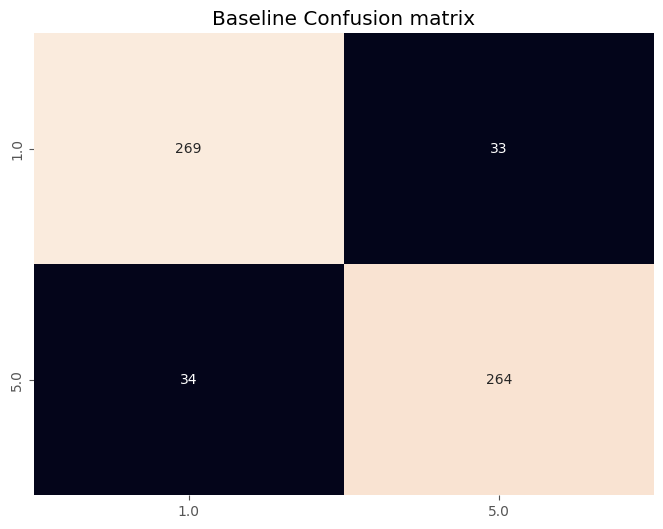

In [158]:
labels = grid_cntv.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions),
    annot=True,
    fmt="d",
    cbar=False,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Baseline Confusion matrix")
plt.show()

In [159]:
# Классификатор - Logistic Regression + CountVectorizer + TfidfTransformer + униграммы, биграммы, триграммы  на базе слов
clf_tf_idf = Pipeline(
    [('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', LogisticRegression())]
)

params_tf_idf={
    'vect__analyzer': ['word'],
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tfidf__use_idf': (True, False),
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l1', 'l2']
}

scores=['accuracy','f1']

In [160]:
grid_tf_idf = GridSearchCV(
    clf_tf_idf,
    param_grid=params_tf_idf,
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1,
    verbose=3
)

In [161]:
grid_tf_idf.fit(X_train, y_train)

Fitting 3 folds for each of 252 candidates, totalling 756 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'clf__penalty': ['l1', 'l2'],
                         'tfidf__use_idf': (True, False),
                         'vect__analyzer': ['word'],
                         'vect__max_df': (0.5, 0.75, 1.0),
                         'vect__ngram_range': [(1, 1), (2, 2), (3, 3)]},
             refit='accuracy', scoring=['accuracy', 'f1'], verbose=3)

In [162]:
predictions = grid_tf_idf.best_estimator_.predict(X_test)

In [163]:
print(f"Best params: {grid_tf_idf.best_params_}")

Best params: {'clf__C': 1000.0, 'clf__penalty': 'l2', 'tfidf__use_idf': True, 'vect__analyzer': 'word', 'vect__max_df': 0.5, 'vect__ngram_range': (1, 1)}


In [164]:
print("Best score: %0.3f" % grid_tf_idf.best_score_)

Best score: 0.921


In [165]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.92      0.92      0.92       302
         5.0       0.92      0.92      0.92       298

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600



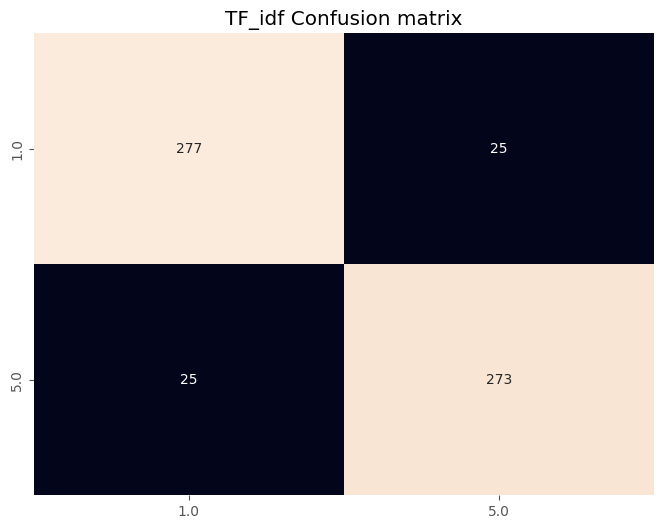

In [166]:
labels = grid_tf_idf.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions),
    annot=True,
    fmt="d",
    cbar=False,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("TF_idf Confusion matrix")
plt.show()

In [167]:
# Сингулярное разложение
clf_tf_idf_TruncatedSVD = Pipeline(
    [('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('tsvd', TruncatedSVD()),
     ('clf', LogisticRegression())]
)

params_tf_idf_TruncatedSVD={
    'vect__analyzer': ['word'],
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tsvd__n_components': [5, 10, 25, 50, 100],
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l1', 'l2']
}

scores=['accuracy','f1']

In [168]:
grid_tf_idf_TruncatedSVD = GridSearchCV(
    clf_tf_idf_TruncatedSVD,
    param_grid=params_tf_idf_TruncatedSVD,
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1,
    verbose=1
)

In [169]:
grid_tf_idf_TruncatedSVD.fit(X_train, y_train)

Fitting 3 folds for each of 210 candidates, totalling 630 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('tsvd', TruncatedSVD()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'clf__penalty': ['l1', 'l2'],
                         'tsvd__n_components': [5, 10, 25, 50, 100],
                         'vect__analyzer': ['word'],
                         'vect__ngram_range': [(1, 1), (2, 2), (3, 3)]},
             refit='accuracy', scoring=['accuracy', 'f1'], verbose=1)

In [170]:
predictions=grid_tf_idf_TruncatedSVD.best_estimator_.predict(X_test)

In [171]:
print(f"Best params: {grid_tf_idf_TruncatedSVD.best_params_}")

Best params: {'clf__C': 100.0, 'clf__penalty': 'l2', 'tsvd__n_components': 100, 'vect__analyzer': 'word', 'vect__ngram_range': (1, 1)}


In [172]:
print("Best score: %0.3f" % grid_tf_idf_TruncatedSVD.best_score_)

Best score: 0.919


In [173]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.92      0.92      0.92       302
         5.0       0.92      0.92      0.92       298

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600



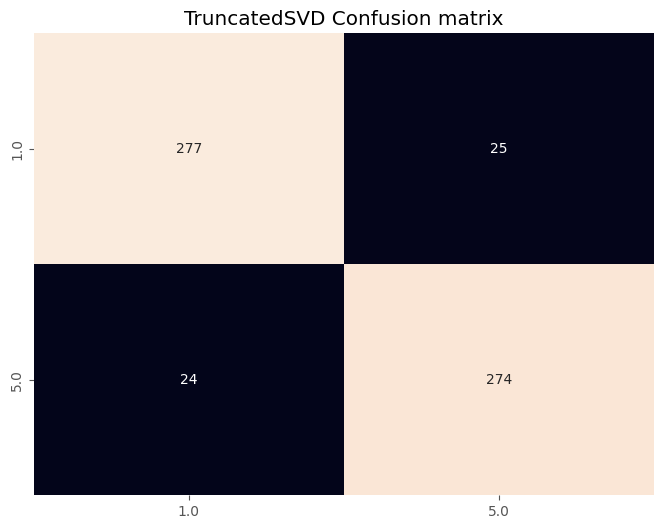

In [174]:
labels = grid_tf_idf_TruncatedSVD.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions),
    annot=True,
    fmt="d",
    cbar=False,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("TruncatedSVD Confusion matrix")
plt.show()

In [180]:
# LDA
clf_tf_idf_LDA = Pipeline(
    [('vect', CountVectorizer()),
     ('lda', LatentDirichletAllocation()),
     ('clf', LogisticRegression())]
)

params_tf_idf_LDA={
    'vect__analyzer': ['word'],
    'vect__max_df': [0.75],
    'vect__ngram_range': [(1, 1)],
    'lda__n_components' : [25, 50, 100],
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l2']
}

scores=['accuracy', 'f1']

In [181]:
grid_tf_idf_LDA = GridSearchCV(
    clf_tf_idf_LDA,
    param_grid=params_tf_idf_LDA,
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1,
    verbose=1
)

In [182]:
grid_tf_idf_LDA.fit(X_train, y_train)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('lda', LatentDirichletAllocation()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'clf__penalty': ['l2'],
                         'lda__n_components': [25, 50, 100],
                         'vect__analyzer': ['word'], 'vect__max_df': [0.75],
                         'vect__ngram_range': [(1, 1)]},
             refit='accuracy', scoring=['accuracy', 'f1'], verbose=1)

In [183]:
predictions=grid_tf_idf_LDA.best_estimator_.predict(X_test)

In [184]:
print(f"Best params: {grid_tf_idf_LDA.best_params_}")

Best params: {'clf__C': 10.0, 'clf__penalty': 'l2', 'lda__n_components': 50, 'vect__analyzer': 'word', 'vect__max_df': 0.75, 'vect__ngram_range': (1, 1)}


In [185]:
print("Best score: %0.3f" % grid_tf_idf_LDA.best_score_)

Best score: 0.833


In [186]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.82      0.81      0.82       302
         5.0       0.81      0.82      0.81       298

    accuracy                           0.81       600
   macro avg       0.82      0.82      0.81       600
weighted avg       0.82      0.81      0.82       600



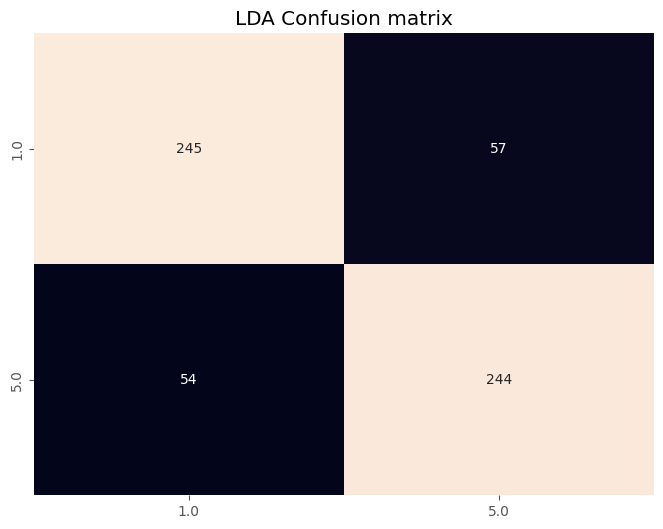

In [187]:
labels = grid_tf_idf_LDA.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions),
    annot=True,
    fmt="d",
    cbar=False,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("LDA Confusion matrix")
plt.show()

In [188]:
models=['grid_cntv', 'grid_tf_idf', 'grid_tf_idf_TruncatedSVD', 'grid_tf_idf_LDA']

for model in models:
    print(model[5:])
    predictions=eval(model).best_estimator_.predict(X_test)
    print("f1_score: {0:6.3f}\nAccuracy: {0:6.3f}\n\n".format(
        f1_score(y_test, predictions, average='macro'),
        accuracy_score(y_test, predictions)))

cntv
f1_score:  0.888
Accuracy:  0.888


tf_idf
f1_score:  0.917
Accuracy:  0.917


tf_idf_TruncatedSVD
f1_score:  0.918
Accuracy:  0.918


tf_idf_LDA
f1_score:  0.815
Accuracy:  0.815




Лучший результат у TruncatedSVD